In [1]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
from dlab.sglx_analysis import readMeta
from dlab import sorting_quality as sq
from matplotlib.gridspec import GridSpec

In [4]:
path = 'Z:\\color_representation\\C51\\20210607_c51_ABC_g1\\'
units_file = glob(path+'*ntermediates\*spiketimes.json')[0]
gratings_file = glob(path+'*ntermediates\*gratings.json')[0]
matrix_file = glob(path+'*ntermediates\*matrices.pkl')[0]

units_df = pd.read_json(open(units_file,'rb'))
matrix_data = pkl.load(open(matrix_file,'rb'))
gratings_data = pd.read_json(open(gratings_file,'rb'))

In [5]:
gratings_data.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times
0,0,orientation,9,2,0.16,45,NaN,NaN,776.91641
1,1,orientation,14,2,0.16,270,NaN,NaN,779.91650
2,2,orientation,8,2,0.16,0,NaN,NaN,782.91634
3,3,orientation,6,2,0.08,270,NaN,NaN,785.91401
4,4,orientation,10,2,0.16,90,NaN,NaN,788.91584


In [6]:
imec0_units = units_df.loc[units_df['probe']=='imec0']
imec0_units.reset_index(inplace = True, drop = True)

imec1_units = units_df.loc[units_df['probe']=='imec1']
imec1_units.reset_index(inplace = True, drop = True)

In [7]:
imec1_units.head()

,probe,unit id,depth,amp,no_spikes,times
0,imec1,7,360,47.4,4,"[3.3904689444000002, 14.290235772900001, 15.30..."
1,imec1,11,460,21.7,4,"[2.6368425141, 3.287636553, 3.3427693814, 3.34..."
2,imec1,13,440,17.4,4,"[0.0994324226, 1.9428155378, 2.4183111824, 2.6..."
3,imec1,15,480,73.0,4,"[79.6596703442, 82.6771760382, 99.4296892575, ..."
4,imec1,19,520,49.2,4,"[0.3064305265, 0.3685966238, 0.4977954404, 0.5..."


**Choose a neuron for visualization**

In [8]:
chosen = 30

### Waveform

In [9]:
probe_folder = glob(path+'\*imec0*')[0] #Change the probe number as necessary
bin_file = glob(probe_folder+'\*ap.bin')[0] #Change the probe number as necessary
imec_meta = readMeta(probe_folder+'\\')
sampRate = float(imec_meta['imSampRate']) #get sampling rate (Hz)

In [10]:
mean_wf = sq.mean_waveform(rawdata=bin_file,times=units_df.times[chosen],channels=385,sampling_rate = float(sampRate))

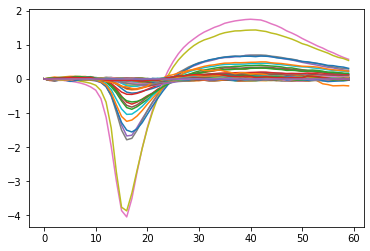

In [12]:
for i in mean_wf:
    plt.plot(i)

### Luminance Receptive Field

Generates maximal receptive field for the highspeed luminance matrix. All RFs at different tau values are contained in `output`

In [13]:
matrix_lum_data = matrix_data['luminance_data']
matrix_lum_times = matrix_data['luminance_times']

In [14]:
def rf_array(spike_data, unit, stim_data, stim_times,num_taus=8):
    spiketimes = np.array(spike_data['times'][unit])
    taus = np.round(np.linspace(-0.01,0.28,num_taus),2)
    srf_list=[]
    
    for k,tau in tqdm(enumerate(taus)):
        idx_arr = []
        stimspikes = []
        spiketime_adj = spiketimes-tau
        for i in range(spiketimes.shape[0]):
            bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
            idx_arr.append(bool_idx)
        spike_adj_stim = spiketime_adj[idx_arr]

        frame_index = []
        for j in range(spike_adj_stim.shape[0]):
            stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
            frame_index.append(stim_frame)    

        srf_frames = data[frame_index]
        srf = srf_frames.mean(axis=(0))
        srf_list.append(srf)

    output = dict(zip(taus,srf_list))
    return(output)

10it [00:00, 49.44it/s]


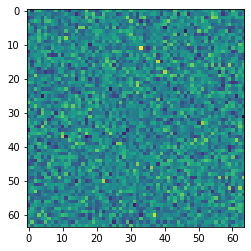

In [15]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_lum_data
datatimes = matrix_lum_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

In [82]:
def rf_grid(data, colormap ='viridis',interp='none',nrows=5,ncols=2):
    fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
    axs = axs.ravel()
    for i,j in tqdm(enumerate(taus)):
        data2 = data[j]
        out_mean = np.mean(data2)
        out_std = np.std(data2)
        col_min = out_mean-(out_std*3)
        col_max = out_mean+(out_std*3)
        #Generate subplots
        axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                      interpolation=interp
                     )
        for ax in fig.get_axes():
            ax.set_frame_on(False);
            ax.set_xticklabels('',visible=False);
            ax.set_xticks([]);
            ax.set_yticklabels('',visible=False);
            ax.set_yticks([])
            ax.set_aspect(1.0)
            ax.set_xlim(0,64)
            ax.set_ylim(0,64)
        plt.tight_layout()
        return(fig)

10it [00:00, 49.80it/s]


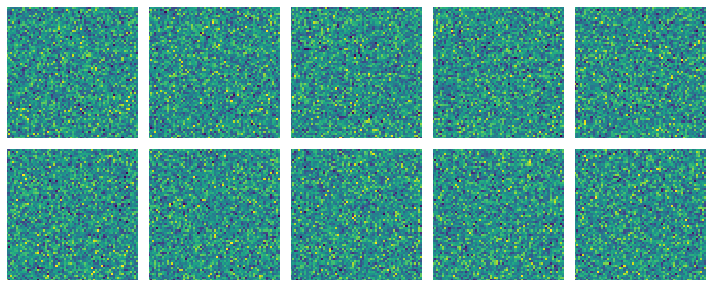

In [17]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = data[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()

## Green Receptive Field

In [18]:
matrix_green_data = matrix_data['green_data']
matrix_color_times = matrix_data['color_times']

10it [00:00, 48.09it/s]


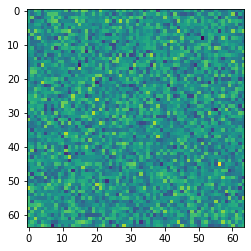

In [19]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_green_data
datatimes = matrix_color_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

10it [00:00, 50.09it/s]


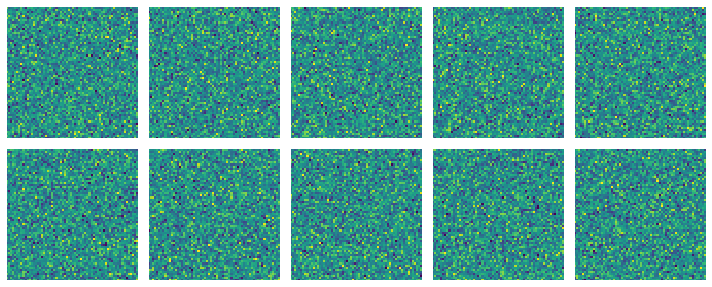

In [20]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = output[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()

### UV Receptive Field

In [21]:
matrix_uv_data = matrix_data['uv_data']

10it [00:00, 50.93it/s]


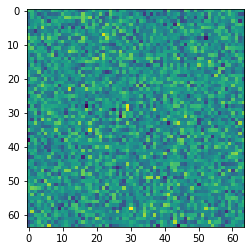

In [22]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_uv_data
datatimes = matrix_color_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

10it [00:00, 49.60it/s]


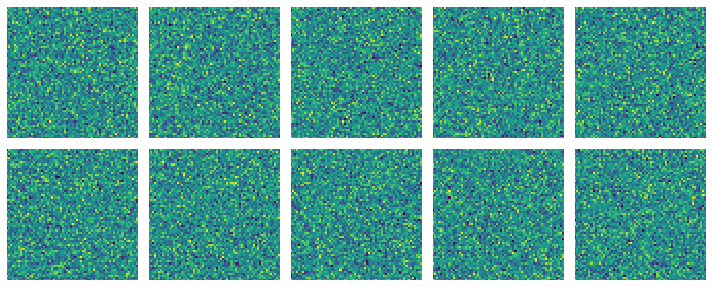

In [23]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = output[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()


### PSTHs for Common Gratings Features

All gratings stimuli have shared features, despite being presented under different LED conditons including spatial frequency and orientation.

In [24]:
data1 = imec0_units; data = pd.DataFrame(data1.reset_index(drop = True))
stim_data = gratings_data; condition='ori'
unit = 42; times = np.array(data.times[unit])
pre = 1; post=2; binsize=0.05
numbins = int((post+pre) / binsize)
x = np.arange(-pre,post,binsize)
colors = plt.cm.viridis(np.linspace(0,1,11))

In [78]:
def psth_line_overlay(spike_data, unit, stim_data, condition, title='', pre=0.5, post=2.5,binsize=0.05,variance=True):
    times = np.array(spike_data.times[unit])
    numbins = int((post+pre)/binsize)
    conds = np.unique(stim_data[condition])
    num_conds = len(conds)
    x = np.arange(-pre,post,binsize)
    colors = plt.cm.viridis(np.linspace(0,1,num_conds))
    
    psth_all=[]
    fig,ax = plt.subplots()
    
    for i,cond in enumerate(np.unique(stim_data[condition])):
        triggers = np.array(stim_data['times'][stim_data[condition] == cond])
        bytrial = np.zeros((len(triggers),numbins-1))
        for j, trigger in enumerate(triggers):
            trial = triggers[j]
            start = trial-pre
            end = trial+post
            bins_ = np.arange(start,end,binsize)
            trial_spikes = times[np.logical_and(times>=start, times<=end)]
            hist,edges = np.histogram(trial_spikes,bins=bins_)
            if len(hist)==numbins-1:
                bytrial[j]=hist
            elif len(hist)==numbins:
                bytrial[j]=hist[:-1]
        psth = np.mean(bytrial,axis=0)/binsize
        if isinstance(conds[i],float)==True:
            ax.plot(x[:-1],psth, color=colors[i], label=str(round(conds[i],2)))
#         if isinstance(conds[i],tuple)==True:
#             ax.plot(x[:-1],psth, color=colors[i], label=str(round(conds[i],2)))
        else:
            ax.plot(x[:-1],psth, color=colors[i], label=str(conds[i]))
        if variance == True:
            var = np.std(bytrial,axis=0)/binsize/np.sqrt((len(triggers)))
            upper = psth+var
            lower = psth-var
            ax.fill_between(x[:-1],upper,psth,alpha=0.1,color=colors[i])
            ax.fill_between(x[:-1],lower,psth,alpha=0.1,color=colors[i])
    ax.axvline(0,linestyle='dashed')
    plt.legend(loc=(1.05,0.48))
    plt.title(title)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    return(fig)

In [81]:
def psth_bars(spike_data,unit,stim_data,condition,title='',pre=0.5,post=2.5,binsize=0.05):
    times = np.array(spike_data.times[unit])
    numbins = int((post+pre)/binsize)
    num_conds = len(np.unique(stim_data[condition]))
    
    psth_all=[]
    fig,ax = plt.subplots(num_conds,1)
    
    for i,cond in enumerate(np.unique(stim_data[condition])):
        triggers = np.array(stim_data['times'][stim_data[condition] == cond])
        bytrial = np.zeros((len(triggers),numbins-1))
        for j, trigger in enumerate(triggers):
            trial = triggers[j]
            start = trial-pre
            end = trial+post
            bins_ = np.arange(start,end,binsize)
            trial_spikes = times[np.logical_and(times>=start, times<=end)]
            hist,edges = np.histogram(trial_spikes,bins=bins_)
            if len(hist)==numbins-1:
                bytrial[j]=hist
            elif len(hist)==numbins:
                bytrial[j]=hist[:-1]
        psth = np.mean(bytrial,axis=0)/binsize
        psth = np.reshape(psth,(1,len(psth)))
        psth_all.append(psth)
        im = ax[i].imshow(psth,aspect=3, vmin=0,vmax=np.max(psth_all),interpolation='gaussian')
        if isinstance(cond,float)==True:
            ax[i].set_ylabel(str(round(cond,2)),rotation=0,labelpad=20,fontsize=12,va='center')
        #elif isinstance(cond,tuple)==True:
            ax[i].set_ylabel(str(cond),rotation=0,labelpad=32,fontsize=10,va='center')
        else:
            ax[i].set_ylabel(str(cond),rotation=0,labelpad=20,fontsize=12,va='center')
        ax[i].set_yticks([])
        ax[i].axvline(pre/binsize,color='r',linewidth=3)
        ax[i].set_xticks([])

    fig.subplots_adjust(hspace=0,wspace=0)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
    fig.suptitle(title, fontsize=15)
    fig.colorbar(im,cax=cbar_ax)
    cbar_ax.set_title('Hz')
    plt.show()
    return(fig)

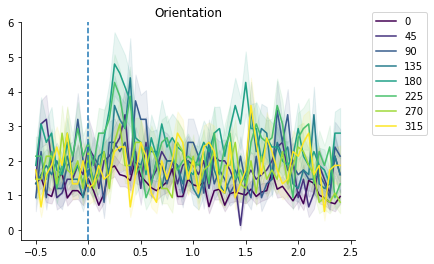

In [79]:
a = psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='ori',
         title = 'Orientation')

In [37]:
np.unique(gratings_data['ori'])

array([  0,  45,  90, 135, 180, 225, 270, 315], dtype=int64)

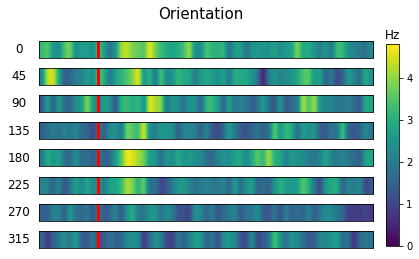

In [28]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='ori',
         title = 'Orientation')

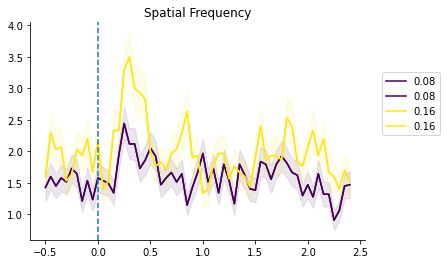

In [40]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='SF',
         title = 'Spatial Frequency')

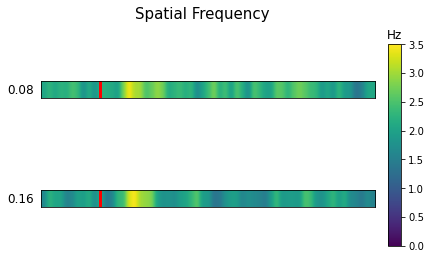

In [30]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='SF',
         title = 'Spatial Frequency')

### Gratings Orientation PSTHs

In [31]:
gratings_orientation = gratings_data[gratings_data['condition']=='orientation']
gratings_orientation.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times
0,0,orientation,9,2,0.16,45,NaN,NaN,776.91641
1,1,orientation,14,2,0.16,270,NaN,NaN,779.91650
2,2,orientation,8,2,0.16,0,NaN,NaN,782.91634
3,3,orientation,6,2,0.08,270,NaN,NaN,785.91401
4,4,orientation,10,2,0.16,90,NaN,NaN,788.91584


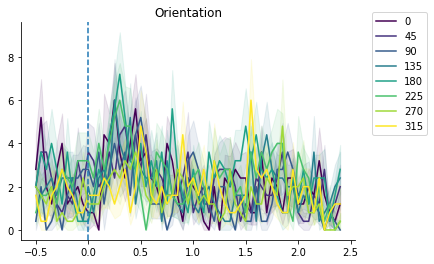

In [41]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='ori',
         title = 'Orientation')

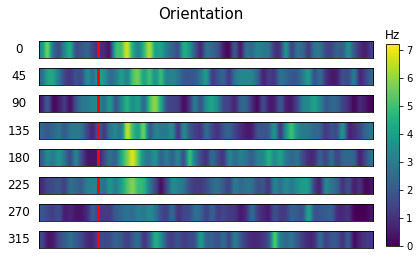

In [42]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='ori',
         title = 'Orientation')

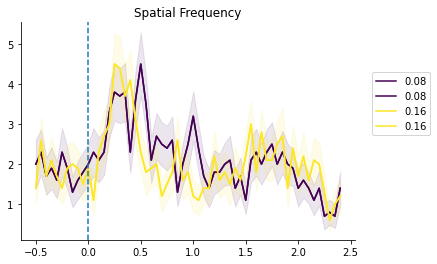

In [43]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='SF',
         title = 'Spatial Frequency')

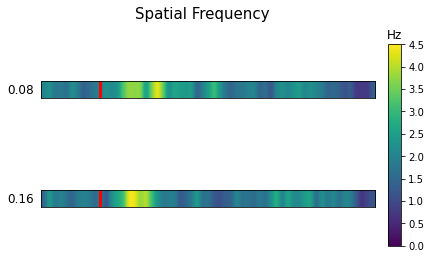

In [44]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='SF',
         title = 'Spatial Frequency')

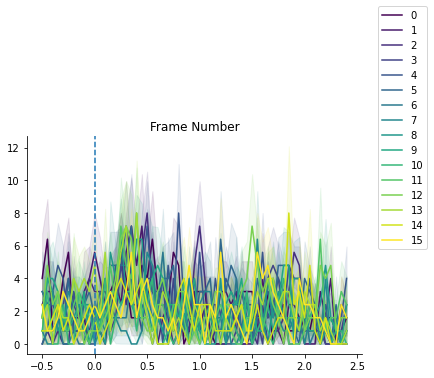

In [45]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='frame_no',
         title = 'Frame Number')

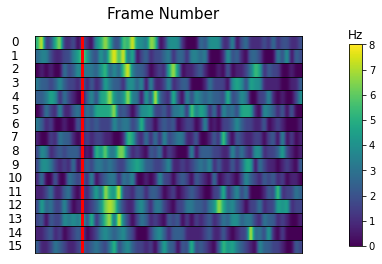

In [46]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='frame_no',
         title = 'Frame Number')

### Gratings Color

In [47]:
gratings_color = gratings_data[gratings_data['condition']=='color']
#gratings_color = gratings_color.sort_values(['green','uv']).reset_index()
gratings_color = gratings_color.drop(columns=['index']).reset_index()
gratings_color.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times
0,400,color,1,2,0.08,0,-0.92,0.73,1988.00044
1,401,color,12,2,0.08,0,1.00,-0.84,1991.00073
2,402,color,2,2,0.08,0,-0.70,0.43,1994.00042
3,403,color,8,2,0.08,0,0.40,-0.39,1996.99973
4,404,color,1,2,0.08,0,-0.92,0.73,1999.99981


In [48]:
color_condition = []
for i in range(gratings_color.shape[0]):
    b = round(gratings_color['uv'][i],2)
    g = round(gratings_color['green'][i],2)
    condition = tuple([g, b])
    color_condition.append(condition)
    
gratings_color['color']=color_condition
gratings_color.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times,color
0,400,color,1,2,0.08,0,-0.92,0.73,1988.00044,"(-0.92, 0.73)"
1,401,color,12,2,0.08,0,1.00,-0.84,1991.00073,"(1.0, -0.84)"
2,402,color,2,2,0.08,0,-0.70,0.43,1994.00042,"(-0.7, 0.43)"
3,403,color,8,2,0.08,0,0.40,-0.39,1996.99973,"(0.4, -0.39)"
4,404,color,1,2,0.08,0,-0.92,0.73,1999.99981,"(-0.92, 0.73)"


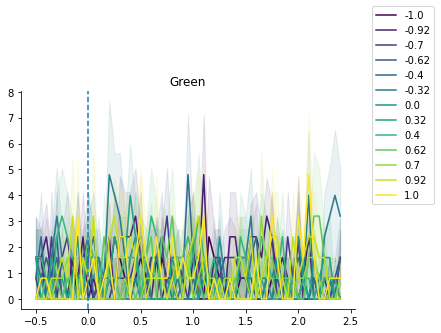

In [65]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='green',
         title = 'Green')

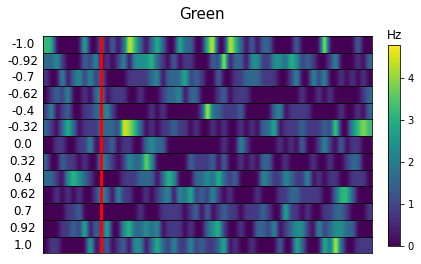

In [50]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='green',
         title = 'Green')

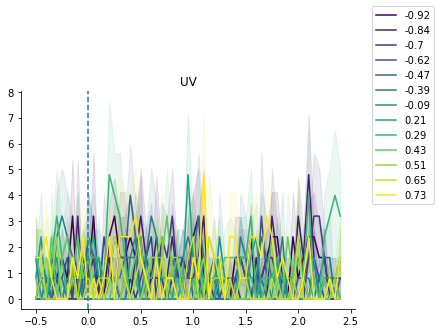

In [66]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='uv',
         title = 'UV')

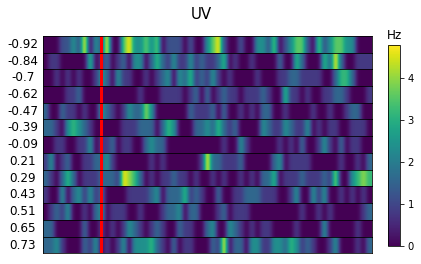

In [51]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='uv',
         title = 'UV')

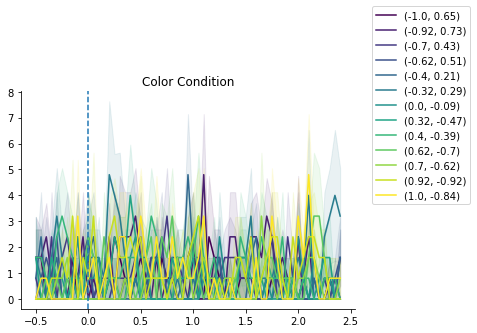

In [67]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='color',
         title = 'Color Condition')

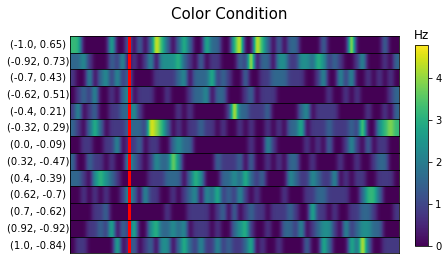

In [52]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='color',
         title = 'Color Condition')

### Gratings Green

In [53]:
gratings_green = gratings_data[gratings_data['condition']=='green']
gratings_green.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times
725,0,green,5,2,0.08,225,NaN,NaN,2989.22833
726,1,green,4,2,0.08,180,NaN,NaN,2992.22891
727,2,green,15,2,0.16,315,NaN,NaN,2995.22820
728,3,green,10,2,0.16,90,NaN,NaN,2998.22794
729,4,green,8,2,0.16,0,NaN,NaN,3001.22782


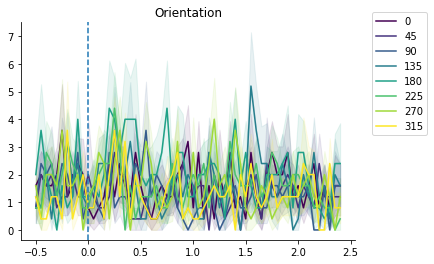

In [68]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='ori',
         title = 'Orientation')

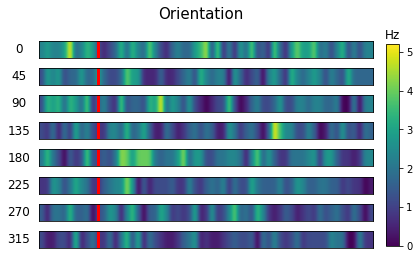

In [54]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='ori',
         title = 'Orientation')

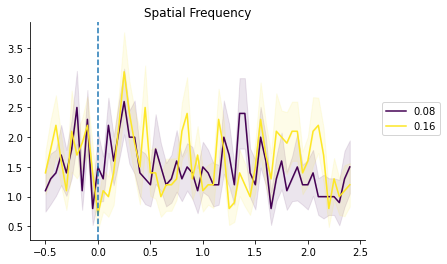

In [69]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='SF',
         title = 'Spatial Frequency')

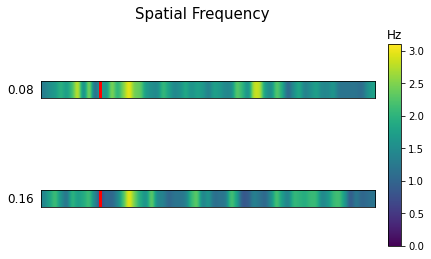

In [55]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='SF',
         title = 'Spatial Frequency')

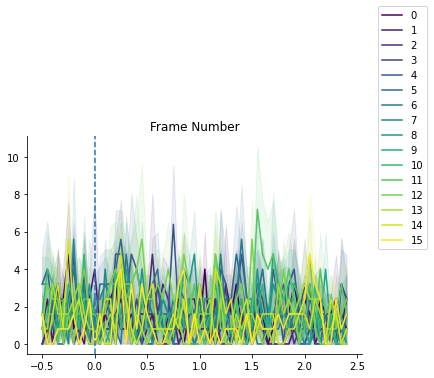

In [70]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='frame_no',
         title = 'Frame Number')

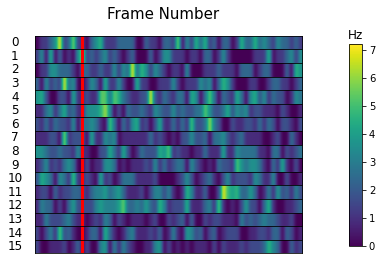

In [56]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='frame_no',
         title = 'Frame Number')

### Gratings UV

In [57]:
gratings_uv = gratings_data[gratings_data['condition']=='uv']
gratings_uv.head()

,index,condition,frame_no,TF,SF,ori,green,uv,times
1125,0,uv,5,2,0.08,225,NaN,NaN,4244.80971
1126,1,uv,1,2,0.08,45,NaN,NaN,4247.81000
1127,2,uv,0,2,0.08,0,NaN,NaN,4250.80930
1128,3,uv,5,2,0.08,225,NaN,NaN,4253.80894
1129,4,uv,3,2,0.08,135,NaN,NaN,4256.80880


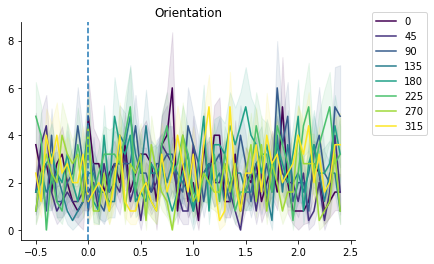

In [71]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='ori',
         title = 'Orientation')

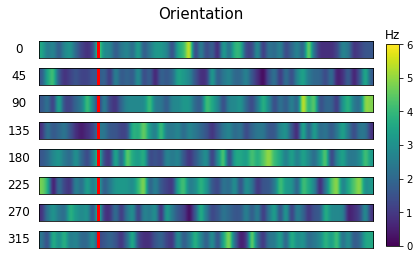

In [58]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='ori',
         title = 'Orientation')

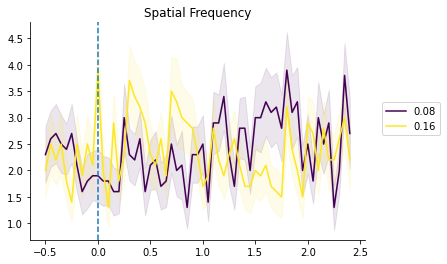

In [72]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='SF',
         title = 'Spatial Frequency')

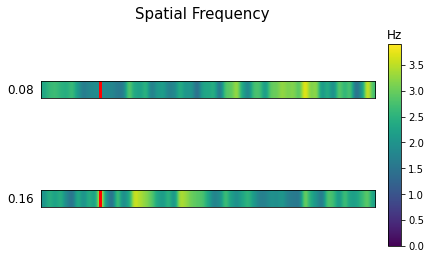

In [59]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='SF',
         title = 'Spatial Frequency')

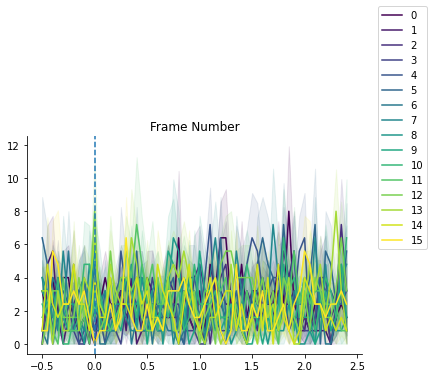

In [75]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='frame_no',
         title = 'Frame Number')

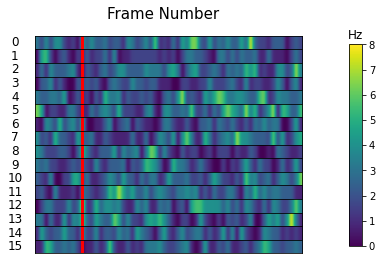

In [60]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='frame_no',
         title = 'Frame Number')

In [ ]:
matrix_data = []
matrix_times = []
gratings_data = []
gratings_conditions = ['orientation','color','green','uv']

def single_cell_summary(path,probe,spike_data,unit,matrix_data,matrix_times,gratings_data,
                        gratings_conditions = ['orientation','color','green','uv'],
                        psth = 'lines',colors='viridis'):
    
    raw_data = glob(path+'*'+str(probe)+'\*ap.bin')
    imec_meta = readMeta(glob(path+'*'+str(probe)+'\*ap.meta'))
    sampRate = float(imec_meta['imSampRate']) #get sampling rate (Hz)
    
    #Separate units by probe
    units_df = spike_data.loc[spike_data['probe']==probe]
    
    #generate waveform figure
    mean_wf = sq.mean_waveform(rawdata=raw_data,times=units_df.times[unit],channels=385,sampling_rate=float(sampRate))
    for i in mean_wf:
        plt.plot(i)
        
    #generate receptive field grid figures
    lum_rfs = rf_array(units_df, unit, stim_data, stim_times)
    green_rfs = rf_array(units_df, unit, stim_data, stim_times)
    uv_rfs = rf_array(units_df, unit, stim_data, stim_times,)
    
    rf_outputs = [lum_rfs,green_rfs, uv_rfs]

    else:
        print('psth options are `line` and `heatmap`')
    
    for i in rf_outputs:
        rf_grid(i,ncols=4)
        

    for i in gratings_conditions:
        gratings_df = gratings_data[gratings_data==i]
        gratings_df = gratings_df.drop(columns=['index']).reset_index()
        
        if i == 'color' or 'Color':
            #
            color_condition = []
            for i in range(gratings_color.shape[0]):
                b = round(gratings_color['uv'][i],2)
                g = round(gratings_color['green'][i],2)
                condition = tuple([g, b])
                color_condition.append(condition)

            gratings_color['color']=color_condition
            gratings_color.head()
            
            
            if psth == 'lines':
            #Generate PSTH for evoked response to green, uv, and combined color condition   
                psth_color = psth_line_overlay(spike_data=units_df, unit=unit, stim_data=gratings_color,condition='color',
                                  title = 'Color Condition')
                psth_green = psth_line_overlay(spike_data=units_df,unit=unit,stim_data=gratings_color,condition='green',
                                  title = 'Green')
                psth_uv = psth_line_overlay(spike_data=units_df,unit=unit,stim_data=gratings_color,condition='uv',
                                  title = 'UV')
                
            if psth == 'heatmap':
                psth_color = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='color',
                          title = 'Color Condition')
                psth_green = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='green',
                          title = 'Green')
                psth_uv = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='uv',
                          title = 'UV')
        else:
            if psth == 'lines':
                psth_ori = psth_line_overlay(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='ori',
                                  title = 'Orientation')
                psth_sf = psth_line_overlay(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='SF',
                                  title = 'Spatial Frequency')
            if psth == 'heatmap':
                psth_ori = psth_bars(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='ori',
                                  title = 'Orientation')
                psth_sf = psth_bars(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='SF',
                                  title = 'Spatial Frequency')


            
            
    